<a href="https://colab.research.google.com/github/MrckHckr/artemis2-go-tests/blob/main/notebooks/01_sls_propulsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test SLS – Propulsione e Strutture
Core Stage (RS‑25)

Obiettivo: probabilità di failure < 1 su 500

Test:
1. Hot Fire Test (green run)
2. Vibrazioni strutturali
3. Thermal cycling
4. Analisi Data Science
5. Survival analysis
6. Anomaly detection su pressioni e temperature

In [29]:
# Import delle librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import weibull_min
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

np.random.seed(42)



1. Hot Fire Test (green run)

In [30]:
# Dati Hot Fire Test
n_tests = 500

shape = 3.0
scale = 1200

time_to_failure = weibull_min.rvs(shape, scale=scale, size=n_tests)

df_life = pd.DataFrame({
    "test_id": range(n_tests),
    "time_to_failure_sec": time_to_failure
})

df_life.head()


,test_id,time_to_failure_sec
0,0,932.513055
1,1,1732.643650
2,2,1315.270910
3,3,1164.114583
4,4,664.269668


In [31]:
# Survival Analysis (Weibull)
params = weibull_min.fit(df_life["time_to_failure_sec"], floc=0)
shape_hat, loc_hat, scale_hat = params

shape_hat, scale_hat


(np.float64(2.932949072830869), np.float64(1197.887689822981))

In [32]:
# Probabilità di failure durante il lancio
mission_time = 520

p_failure = weibull_min.cdf(mission_time, shape_hat, scale=scale_hat)

print(f"P(failure) = {p_failure:.6f}")
print(f"≈ 1 su {1/p_failure:.0f}")


P(failure) = 0.082873
≈ 1 su 12


In [33]:
# Simulazione sensori (pressione & temperatura)
time = np.arange(0, 520)

pressure = np.random.normal(3000, 50, size=len(time))
temperature = np.random.normal(3300, 40, size=len(time))

pressure[120] += 300
temperature[350] += 250
pressure[480] -= 400

df_sensors = pd.DataFrame({
    "time_sec": time,
    "pressure": pressure,
    "temperature": temperature
})

df_sensors.head()


,time_sec,pressure,temperature
0,0,3017.087799,3245.605754
1,1,3093.808542,3329.850143
2,2,3047.521192,3325.819367
3,3,2971.154817,3386.530189
4,4,2955.079266,3287.688871


In [34]:
# Anomaly Detection
# Normalizzazione dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sensors[["pressure", "temperature"]])

# Modello di rilevamento anomalie
model = IsolationForest(contamination=0.01, random_state=42)
df_sensors["anomaly"] = model.fit_predict(X_scaled)


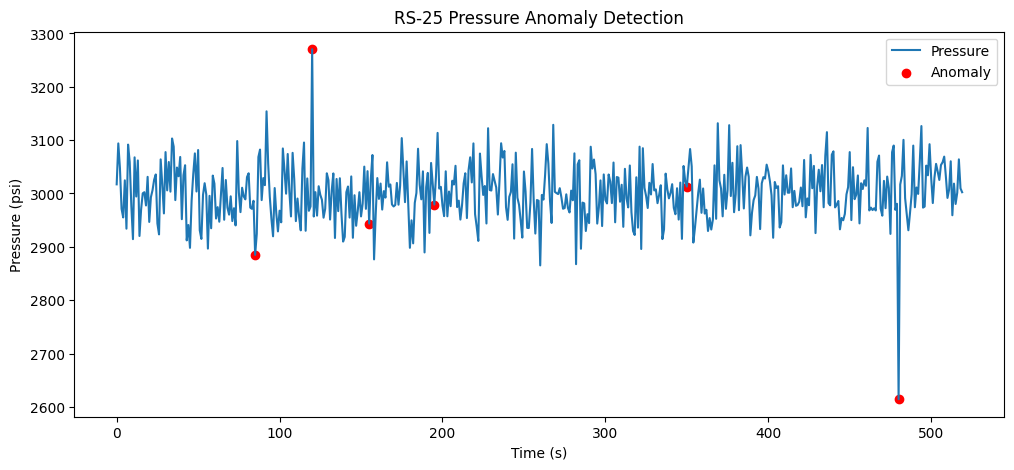

In [35]:
# Visualizzazione anomalie
plt.figure(figsize=(12,5))
plt.plot(df_sensors["time_sec"], df_sensors["pressure"], label="Pressure")
plt.scatter(
    df_sensors[df_sensors["anomaly"] == -1]["time_sec"],
    df_sensors[df_sensors["anomaly"] == -1]["pressure"],
    color="red",
    label="Anomaly"
)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (psi)")
plt.legend()
plt.title("RS-25 Pressure Anomaly Detection")
plt.show()


In [36]:
# ======================================
# Decisione GO / NO-GO per pressione e temperatura
# ======================================

# Definiamo il numero massimo di anomalie consentite
max_allowed_anomalies = 3

# Conta le anomalie rilevate (-1 indica anomalia)
anomalies_detected = (df_sensors["anomaly"] == -1).sum()

# Decisione GO / NO-GO
if anomalies_detected <= max_allowed_anomalies:
    print("✅ GO: Pressione e Temperatura nei limiti")
else:
    print("❌ NO-GO: Anomalie nei sensori, revisione necessaria")

# Mostriamo anche i dettagli numerici
print(f"\nDettaglio:")
print(f"- Anomalie rilevate: {anomalies_detected}")
print(f"- Massimo consentito: {max_allowed_anomalies}")


❌ NO-GO: Anomalie nei sensori, revisione necessaria

Dettaglio:
- Anomalie rilevate: 6
- Massimo consentito: 3


2. Vibrazioni strutturali

*  Simulare un segnale di vibrazione
*  Calcolare la FFT (Fast Fourier Transform) per vedere le frequenze dominanti
*   Confrontare con le frequenze critiche di sicurezza
*   Decidere GO / NO-GO





In [37]:
# Simulazione dati sensori
# Simulazione segnale vibrazionale (accelerometro in g)
fs = 1000  # frequenza di campionamento Hz
t = np.linspace(0, 5, fs*5)  # 5 secondi di test
# Frequenze naturali del motore
freq1 = 50   # Hz
freq2 = 120  # Hz
freq3 = 300  # Hz

# Segnale simulato: somma di sinusoidi + rumore
signal = (
    0.5 * np.sin(2*np.pi*freq1*t) +
    0.3 * np.sin(2*np.pi*freq2*t) +
    0.2 * np.sin(2*np.pi*freq3*t) +
    0.05 * np.random.randn(len(t))
)

df_vib = pd.DataFrame({"time_s": t, "acc_g": signal})
df_vib.head()


,time_s,acc_g
0,0.000000,0.102810
1,0.001000,0.494963
2,0.002000,0.464615
3,0.003001,0.504417
4,0.004001,0.718662


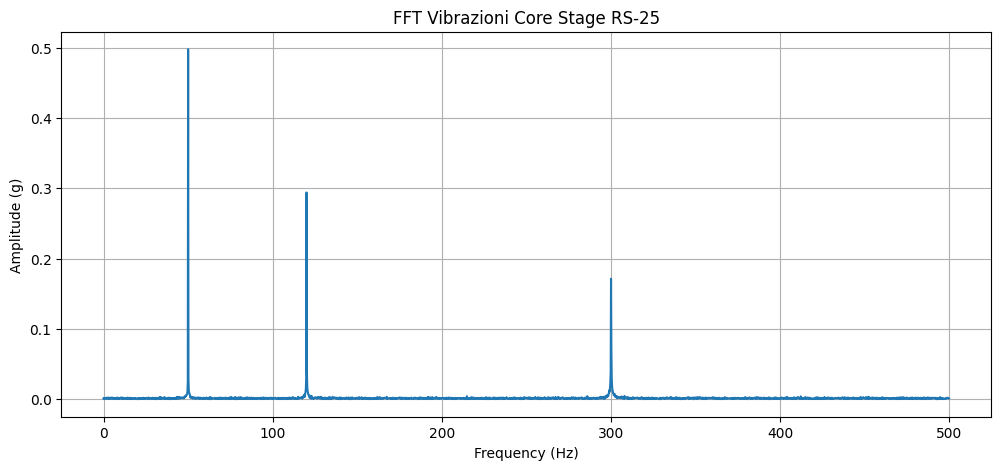

In [38]:
# Calcolo FFT
from scipy.fft import fft, fftfreq

N = len(t)
yf = fft(signal)
xf = fftfreq(N, 1/fs)[:N//2]  # frequenze positive
yf_mag = 2.0/N * np.abs(yf[0:N//2])

plt.figure(figsize=(12,5))
plt.plot(xf, yf_mag)
plt.title("FFT Vibrazioni Core Stage RS-25")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (g)")
plt.grid(True)
plt.show()


In [39]:
# Rilevamento automatico picchi / risonanze
from scipy.signal import find_peaks

# Trova picchi nella FFT sopra una soglia
threshold = 0.15  # ampiezza minima per considerare picco rilevante
peaks, _ = find_peaks(yf_mag, height=threshold)

peak_freqs = xf[peaks]
peak_amps = yf_mag[peaks]

print("Frequenze risonanti rilevate (Hz) e ampiezze (g):")
for f, a in zip(peak_freqs, peak_amps):
    print(f"{f:.1f} Hz -> {a:.3f} g")


Frequenze risonanti rilevate (Hz) e ampiezze (g):
50.0 Hz -> 0.498 g
120.0 Hz -> 0.294 g
300.0 Hz -> 0.171 g


In [40]:
# Decisione GO / NO-GO
# Frequenze critiche di sicurezza (Hz)
critical_freqs = [60, 150, 320]  # esempio NASA
safety_margin = 5  # Hz

# Verifica se picchi sono troppo vicini a frequenze critiche
vib_ok = True
for f in peak_freqs:
    if any(abs(f - cf) < safety_margin for cf in critical_freqs):
        vib_ok = False
        break

if vib_ok:
    print("✅ GO: Vibrazioni strutturali entro limiti di sicurezza")
else:
    print("❌ NO-GO: Vibrazioni critiche rilevate, revisione necessaria")


✅ GO: Vibrazioni strutturali entro limiti di sicurezza
